# SkinLesion - Desafio ISIC 2019 - EfficientNets
Pré-treinadas com o ImageNet.

## Pipeline checklist

1. *Path* do modelo a ser carregado;
2. Configurações da *learning rate*;
3. Épocas de treinamento (inicial e final);
4. Nome do modelo a ser salvo (número da época final).


## To do:


* Trocar **MICRO** F1-score por *weighted* F1-score:
  * Da forma como a média micro é implementada, seus resultados são iguais (literalmente, os mesmos) aos da acurácia.
*   List item



## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install tensorflow_addons
import tensorflow_addons as tfa

2021-11-02 16:14:38.233826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Download dos arquivos do Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip files
!unzip "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/img_shades_cc.zip" -d "."

Streaming output truncated to the last 5000 lines.
  inflating: ./img_shades_cc/ISIC_0065329.jpg  
  inflating: ./img_shades_cc/ISIC_0066774_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0063650.jpg  
  inflating: ./img_shades_cc/ISIC_0033940.jpg  
  inflating: ./img_shades_cc/ISIC_0071678_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0027338.jpg  
  inflating: ./img_shades_cc/ISIC_0056929_aug1.jpg  
  inflating: ./img_shades_cc/ISIC_0061512.jpg  
  inflating: ./img_shades_cc/ISIC_0069094.jpg  
  inflating: ./img_shades_cc/ISIC_0064328_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0033524.jpg  
  inflating: ./img_shades_cc/ISIC_0024390.jpg  
  inflating: ./img_shades_cc/ISIC_0056193_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0028938.jpg  
  inflating: ./img_shades_cc/ISIC_0069119.jpg  
  inflating: ./img_shades_cc/ISIC_0029835.jpg  
  inflating: ./img_shades_cc/ISIC_0069321.jpg  
  inflating: ./img_shades_cc/ISIC_0060482.jpg  
  inflating: ./img_shades_cc/ISIC_0009884.jpg  
  inflating:

Abertura dos dataframes

In [3]:
# Open dataframes containing the images for training, validation and test
train_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train.csv")

aug_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train_aug1.csv")

val_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_val.csv")

test_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_test.csv")

## Treinamento da arquitetura EfficientNet-***B2***

### Dependências
#### Métricas

In [4]:
# Multiclass F1-score MICRO Avg.
micro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='micro',
    name="Micro F1",
)

# Multiclass F1-score MACRO Avg.
macro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='macro',
    name="Macro F1",
)

#### Cálculo dos pesos das classes

In [5]:
# Compute class' weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_df.lesion),
                                     train_df.lesion)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 3.651359143327842, 1: 0.9528697334479793, 2: 1.206518780620577, 3: 13.271706586826348, 4: 0.7002764612954187, 5: 0.2459359742565468, 6: 5.037215909090909, 7: 12.521892655367232}


### Geradores dos tensores (**B2**)

In [6]:
IMG_SIZE = 260
BATCH_SIZE = 32

train_dataGen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataGen.flow_from_dataframe(
    dataframe=aug_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

val_generator = train_dataGen.flow_from_dataframe(
    dataframe=val_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_generator = train_dataGen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 26450 validated image filenames.
Found 5066 validated image filenames.
Found 2534 validated image filenames.


### Instanciação da arquitetura

In [7]:
# # Load EfficientNet pre-trained w/ ImageNet
# base_model = EfficientNetB2(include_top=False, weights="imagenet")

# # Rebuild top
# avg = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
# norm = layers.BatchNormalization()(avg)
# dropout = layers.Dropout(0.35, name="top_dropout")(norm)
# output = layers.Dense(8, activation="softmax", name="pred")(dropout)

# model = tf.keras.Model(base_model.input, output, name="EfficientNetB2")

# # Freeze the pretrained weights
# for layer in base_model.layers:
#     layer.trainable = False

### Otimizador **SGD com Nesterov**

#### Treinamento das camadas superiores

In [8]:
# # Load previous best weights
# # model.load_weights(
# #      '/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_15top10').expect_partial()

# # Learning rate scheduler
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=827*5,
#     decay_rate=0.1,
#     staircase=True)

# # Optimizer setup
# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# # Metrics
# metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
#            micro_f1, macro_f1]

# # Compile model
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",
#               metrics=metrics)

In [9]:
# # Save model's best weights based on validation loss
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovTop{epoch:02d}",
#     monitor='loss', verbose=1, save_best_only=True,
#     save_weights_only=False, mode='min')

# # Top layers training: Epochs - min:8; max:80
# history = model.fit(train_generator, validation_data=val_generator, epochs=20,
#                     class_weight=class_weights,
#                     callbacks=[checkpoint])

In [10]:
# # Make new dataframe containing model's top training history
# top_history = pd.DataFrame.from_dict(history.history)

# # Save metrics' history as CSV
# top_history.to_csv(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovTopHistory.csv",
#     index=False)

In [11]:
# # Save whole model with the top trained
# model.save(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovTop20")

##### Resultado do treinamento das camadas superiores

In [12]:
# # Summarize history for loss
# plt.plot(top_history['loss'])
# plt.plot(top_history['val_loss'])
# plt.title('Model\'s loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for accuracy
# plt.plot(top_history['Categorical Accuracy'])
# plt.plot(top_history['val_Categorical Accuracy'])
# plt.title('Model\'s accuracy')
# plt.ylabel('Categorical Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for MACRO avg. F1-Score
# plt.plot(top_history['Macro F1'])
# plt.plot(top_history['val_Macro F1'])
# plt.title('Model\'s macro averaged F1-Score')
# plt.ylabel('Macro avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for MICRO avg. F1
# plt.plot(top_history['Micro F1'])
# plt.plot(top_history['val_Micro F1'])
# plt.title('Model\'s micro averaged F1-Score')
# plt.ylabel('Micro avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

#### Treinamento de todas as camadas

In [13]:
# Load FULL model
model = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull_40")

In [14]:
# Unfreeze all layer's pretrained weights
# for layer in model.layers:
#     layer.trainable = True

In [15]:
# Learning rate scheduler
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*10,
#     decay_rate=0.1,
#     staircase=True)

# Change learning rate after a few epochs of training
model.optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-4, momentum=0.9, nesterov=True)

# Verify changes
model.optimizer.get_config()

{'decay': 0.0,
 'learning_rate': 0.0001,
 'momentum': 0.9,
 'name': 'SGD',
 'nesterov': True}

In [16]:
# Save whole model's state based on validation loss (best only)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull{epoch:02d}",
    monitor='loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

In [17]:
# ALL layers training (CHECK 'epoch' and 'initial_epoch' before start)
history = model.fit(train_generator, validation_data=val_generator, epochs=60,
                    class_weight=class_weights,
                    callbacks=[checkpoint],
                    initial_epoch=40)

Epoch 41/60
827/827 [==============================] - 522s 584ms/step - loss: 4.5866 - Categorical Accuracy: 0.1875 - Micro F1: 0.1875 - Macro F1: 0.0612 - val_loss: 2.1329 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00041: loss improved from inf to 4.58657, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull41
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull41/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull41/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/60
827/827 [==============================] - 454s 549ms/step - loss: 4.5705 - Categorical Accuracy: 0.1900 - Micro F1: 0.1900 - Macro F1: 0.0598 - val_loss: 2.1558 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00042: loss improved from 4.58657 to 4.57046, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull42
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull42/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull42/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/60
827/827 [==============================] - 430s 520ms/step - loss: 4.5518 - Categorical Accuracy: 0.1911 - Micro F1: 0.1911 - Macro F1: 0.0605 - val_loss: 2.1451 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00043: loss improved from 4.57046 to 4.55180, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull43
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull43/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull43/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/60
827/827 [==============================] - 433s 524ms/step - loss: 4.5278 - Categorical Accuracy: 0.1942 - Micro F1: 0.1942 - Macro F1: 0.0600 - val_loss: 2.1410 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00044: loss improved from 4.55180 to 4.52776, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull44
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull44/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull44/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 45/60
827/827 [==============================] - 429s 519ms/step - loss: 4.5513 - Categorical Accuracy: 0.1948 - Micro F1: 0.1948 - Macro F1: 0.0592 - val_loss: 2.1320 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00045: loss did not improve from 4.52776
Epoch 46/60
827/827 [==============================] - 432s 523ms/step - loss: 4.5325 - Categorical Accuracy: 0.1978 - Micro F1: 0.1978 - Macro F1: 0.0594 - val_loss: 2.1565 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00046: loss did not improve from 4.52776
Epoch 47/60
827/827 [==============================] - 435s 526ms/step - loss: 4.5253 - Categorical Accuracy: 0.1979 - Micro F1: 0.1979 - Macro F1: 0.0615 - val_loss: 2.1358 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00047: loss improved from 4.52776 to 4.52533, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull47/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/60
827/827 [==============================] - 427s 516ms/step - loss: 4.5376 - Categorical Accuracy: 0.1981 - Micro F1: 0.1981 - Macro F1: 0.0604 - val_loss: 2.1356 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00048: loss did not improve from 4.52533
Epoch 49/60
827/827 [==============================] - 425s 513ms/step - loss: 4.5392 - Categorical Accuracy: 0.2012 - Micro F1: 0.2012 - Macro F1: 0.0602 - val_loss: 2.1467 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00049: loss did not improve from 4.52533
Epoch 50/60
827/827 [==============================] - 424s 513ms/step - loss: 4.5180 - Categorical Accuracy: 0.1984 - Micro F1: 0.1984 - Macro F1: 0.0601 - val_loss: 2.1258 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00050: loss improved from 4.52533 to 4.51803, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull50/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 51/60
827/827 [==============================] - 427s 516ms/step - loss: 4.5015 - Categorical Accuracy: 0.1999 - Micro F1: 0.1999 - Macro F1: 0.0603 - val_loss: 2.1309 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00051: loss improved from 4.51803 to 4.50152, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull51
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull51/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull51/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 52/60
827/827 [==============================] - 429s 519ms/step - loss: 4.5036 - Categorical Accuracy: 0.2025 - Micro F1: 0.2025 - Macro F1: 0.0600 - val_loss: 2.1476 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00052: loss did not improve from 4.50152
Epoch 53/60
827/827 [==============================] - 427s 516ms/step - loss: 4.5123 - Categorical Accuracy: 0.2028 - Micro F1: 0.2028 - Macro F1: 0.0597 - val_loss: 2.1320 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00053: loss did not improve from 4.50152
Epoch 54/60
827/827 [==============================] - 436s 528ms/step - loss: 4.4990 - Categorical Accuracy: 0.2039 - Micro F1: 0.2039 - Macro F1: 0.0620 - val_loss: 2.1300 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00054: loss improved from 4.50152 to 4.49902, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull54/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 55/60
827/827 [==============================] - 434s 524ms/step - loss: 4.5076 - Categorical Accuracy: 0.2068 - Micro F1: 0.2068 - Macro F1: 0.0590 - val_loss: 2.1421 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00055: loss did not improve from 4.49902
Epoch 56/60
827/827 [==============================] - 440s 532ms/step - loss: 4.4900 - Categorical Accuracy: 0.2050 - Micro F1: 0.2050 - Macro F1: 0.0603 - val_loss: 2.1537 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00056: loss improved from 4.49902 to 4.48998, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull56
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull56/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull56/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 57/60
827/827 [==============================] - 439s 530ms/step - loss: 4.4937 - Categorical Accuracy: 0.2037 - Micro F1: 0.2037 - Macro F1: 0.0598 - val_loss: 2.1467 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00057: loss did not improve from 4.48998
Epoch 58/60
827/827 [==============================] - 432s 523ms/step - loss: 4.4901 - Categorical Accuracy: 0.2025 - Micro F1: 0.2025 - Macro F1: 0.0590 - val_loss: 2.1465 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00058: loss did not improve from 4.48998
Epoch 59/60
827/827 [==============================] - 429s 518ms/step - loss: 4.4900 - Categorical Accuracy: 0.2081 - Micro F1: 0.2081 - Macro F1: 0.0594 - val_loss: 2.1569 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379

Epoch 00059: loss did not improve from 4.48998
Epoch 60/60
827/827 [==============================] - 430s 519ms/step - loss: 4.4943 - Cat

In [18]:
# Open csv with top layers' training metrics
history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovHistory.csv")

# Make new dataframe with current values
new_entries = pd.DataFrame.from_dict(history.history)

# Append new values to old dataframe
history_df = history_df.append(new_entries, ignore_index=True)

# Save metrics' history as CSV
history_df.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovHistory.csv",
    index=False)

In [19]:
# Save whole model (CHECK CURRENT EPOCH BEFORE SAVING)
model.save(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull_60")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull_60/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovFull_60/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


##### Resultados

Valores de perda do conjunto de treino e de validação

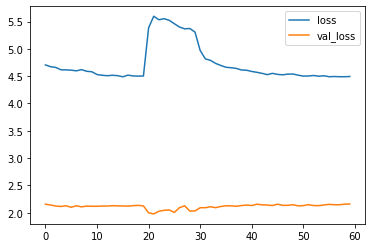

In [20]:
# history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_history.csv")
history_df.plot(y=['loss', 'val_loss'])

Valores de perda do conjunto de validação

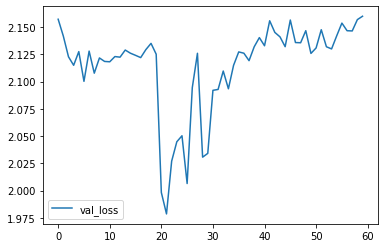

In [21]:
history_df.plot(y='val_loss')

Todas as métricas

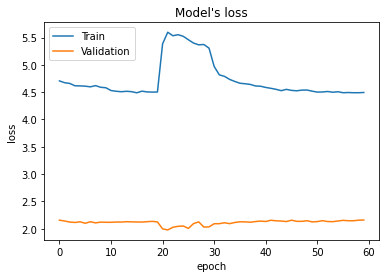

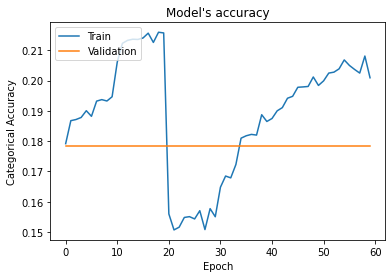

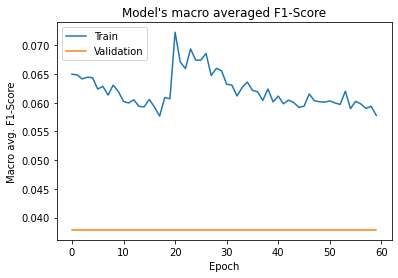

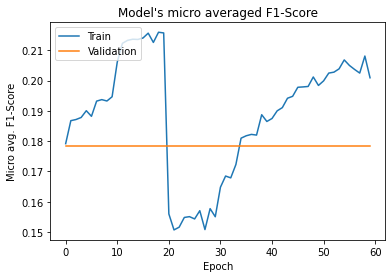

In [22]:
# history_df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_history.csv")

# Summarize history for loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for accuracy
plt.plot(history_df['Categorical Accuracy'])
plt.plot(history_df['val_Categorical Accuracy'])
plt.title('Model\'s accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MACRO avg. F1-Score
plt.plot(history_df['Macro F1'])
plt.plot(history_df['val_Macro F1'])
plt.title('Model\'s macro averaged F1-Score')
plt.ylabel('Macro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MICRO avg. F1
plt.plot(history_df['Micro F1'])
plt.plot(history_df['val_Micro F1'])
plt.title('Model\'s micro averaged F1-Score')
plt.ylabel('Micro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testes

### Conjunto de validação

In [23]:
model = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_nesterovTop_20")

In [24]:
# Predicts labels
val_predictions = model.predict(val_generator, verbose=1)

print(classification_report(val_generator.labels.argmax(1),
                            val_predictions.argmax(1), zero_division=0))

159/159 [==============================] - 63s 383ms/step
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       904
           1       0.00      0.00      0.00      2575
           2       0.00      0.00      0.00       665
           3       0.00      0.00      0.00       173
           4       0.00      0.00      0.00       525
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        51
           7       0.00      0.00      0.00       125

    accuracy                           0.18      5066
   macro avg       0.02      0.12      0.04      5066
weighted avg       0.03      0.18      0.05      5066



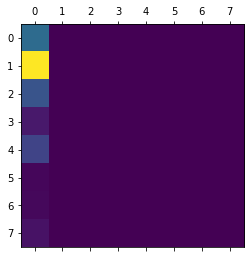

In [25]:
# Confusion matrix
confusion = tf.math.confusion_matrix(val_generator.labels.argmax(1),
                                     val_predictions.argmax(1))

plt.matshow(confusion)

In [26]:
confusion_matrix = confusion.numpy()

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = np.divide(TP, (TP+FN),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FN) != 0))

# Specificity or true negative rate
TNR = np.divide(TN, (TN+FP),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FP) != 0))

# Precision or positive predictive value
PPV = np.divide(TP, (TP+FP),
                out=np.zeros(TP.shape, dtype=float),
                where=((TP+FP) != 0))

# Negative predictive value
NPV = np.divide(TN, (TN+FN),
                out=np.zeros(TN.shape, dtype=float),
                where=((TN+FN) != 0))

# Fall out or false positive rate
FPR = np.divide(FP, (FP+TN),
                out=np.zeros(FP.shape, dtype=float),
                where=((FP+TN) != 0))

# False negative rate
FNR = np.divide(FN, (TP+FN),
                out=np.zeros(FN.shape, dtype=float),
                where=((TP+FN) != 0))

# False discovery rate
FDR = np.divide(FP, (TP+FP),
                out=np.zeros(FP.shape, dtype=float),
                where=((TP+FP) != 0))

# Overall accuracy
ACC = np.divide((TP+TN), (TP+FP+FN+TN),
                out=np.zeros((TP+TN).shape, dtype=float),
                where=((TP+FP+FN+TN) != 0))

# c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
print("True positive:  {}".format(TP))
print("True negative:  {}".format(TN))
print("False positive: {}".format(FP))
print("False negative: {}".format(FN), end="\n\n")

print("Sensibilidade:  {}".format(TPR))
print("Especificidade: {}".format(TNR))
print("Precisão:       {}".format(PPV))
print("Acurácia:       {}".format(ACC))

True positive:  [904   0   0   0   0   0   0   0]
True negative:  [   0 2491 4401 4893 4541 5018 5015 4941]
False positive: [4162    0    0    0    0    0    0    0]
False negative: [   0 2575  665  173  525   48   51  125]

Sensibilidade:  [1. 0. 0. 0. 0. 0. 0. 0.]
Especificidade: [0. 1. 1. 1. 1. 1. 1. 1.]
Precisão:       [0.17844453 0.         0.         0.         0.         0.
 0.         0.        ]
Acurácia:       [0.17844453 0.49170944 0.86873273 0.96585077 0.89636794 0.99052507
 0.98993289 0.9753257 ]


### Modelo p/ copiar e colar

*   Batch size: 32;
*   Topo treinado por XX épocas;
*   Número de épocas de treinamento: YY;
*   *Learning rate*: ZZ;

In [27]:
# Predicts labels
# test_predictions = model.predict(test_generator, verbose=1)

# print(classification_report(
#     test_generator.labels.argmax(1),
#     test_predictions.argmax(1),
#     zero_division=0))

In [28]:
# # Confusion matrix
# confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
#                                      test_predictions.argmax(1))

# plt.matshow(confusion)